In [3]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib as mpl

from functools import partial

import time
import scipy.stats as stats
import seaborn as sns
#import arviz as az

#import constants

from tqdm.auto import tqdm
tqdm.pandas()
from tqdm import tqdm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

pd.set_option('display.max_columns', None)

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

/opt/anaconda3/envs/post_boda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/sq/pxxh686s20scbcsrvq340czj6yvqp0/T/ipykernel_57348/4278997187.py:26: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
def parallel_coordinates(frame, class_column, cols=None, ax=None, color=None,
                     use_columns=False, xticks=None, colormap=None, force_y_label=None,
                         force_title=None, **kwds):
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    n = len(frame)
    class_col = frame[class_column]
    class_min = np.amin(class_col)
    class_max = np.amax(class_col)

    if cols is None:
        df = frame.drop(class_column, axis=1)
    else:
        df = frame[cols]

    used_legends = set([])

    ncols = len(df.columns)

    # determine values to use for xticks
    if use_columns is True:
        if not np.all(np.isreal(list(df.columns))):
            raise ValueError('Columns must be numeric to be used as xticks')
        x = df.columns
    elif xticks is not None:
        if not np.all(np.isreal(xticks)):
            raise ValueError('xticks specified must be numeric')
        elif len(xticks) != ncols:
            raise ValueError('Length of xticks must match number of columns')
        x = xticks
    else:
        x = range(ncols)

    fig = plt.figure(figsize=(10,10))
    ax = plt.gca()

    Colorm = plt.get_cmap(colormap)

    for i in range(n):
        y = df.iloc[i].values
        kls = class_col.iat[i]
        ax.plot(x, y, color=Colorm((kls - class_min)/(class_max-class_min)), **kwds)

    for i in x:
        ax.axvline(i, linewidth=1, color='black')
    
    if force_y_label: 
        plt.ylabel(force_y_label)
    if force_title:
        plt.title(force_title)
    
    ax.set_xticks(x)
    ax.set_xticklabels(df.columns)
    ax.set_xlim(x[0], x[-1])
    ax.legend(loc='upper right')
    ax.grid()

    bounds = np.linspace(class_min, class_max, 10)
    cax,_ = mpl.colorbar.make_axes(ax)
    cb = mpl.colorbar.ColorbarBase(cax, cmap=Colorm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%.2f')
    
    #ax.set_xticks(rot=90)
    return fig, ax

In [5]:
boda2_df = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/BODA2_MPRA_results_pred_contributions_v3.txt', sep=" ", low_memory=False)


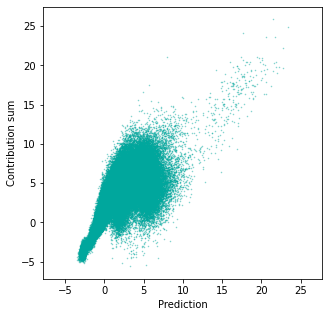

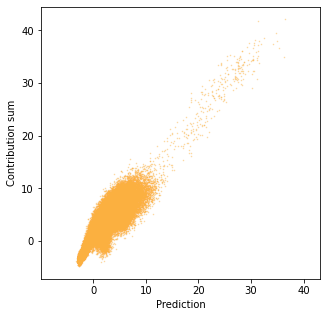

In [55]:
# boda2_df = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/BODA2_MPRA_results_pred_contributions_v1_1.txt', sep=" ", low_memory=False)

# def dna2tensor(sequence_str, vocab_list=['A', 'C', 'G', 'T']):
#         seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
#         for letterIdx, letter in enumerate(sequence_str):
#             seq_tensor[vocab_list.index(letter), letterIdx] = 1
#         seq_tensor = torch.Tensor(seq_tensor)
#         return seq_tensor
    
# def str2tensor(array_string):
#     return torch.tensor([float(item) for item in array_string.lstrip('[[ ').rstrip(' ]]').split(' ') if item != ''])

# no_controls_df = boda2_df[boda2_df['method'].notnull()].reset_index(drop=True)

# #For sorting purposes
# no_controls_df = no_controls_df.sort_values('ID').reset_index(drop=True)

# sequence_column_name = 'sequence'
# #contribution_columns = ['contrib_K562', 'contrib_HepG2', 'contrib_SKNSH']
# contribution_columns = ['contrib_K562_v1_1', 'contrib_HepG2_v1_1']#, 'contrib_SKNSH_v1_1']
# onehot_sequences = torch.stack([dna2tensor(seq) for seq in no_controls_df[sequence_column_name].tolist()])

# contribution_tensor = []
# for contribution_column in contribution_columns: #tqdm(contribution_columns):
#     flat_contributions = torch.stack([str2tensor(contributions).repeat(4,1) \
#                                       for contributions in no_controls_df[contribution_column]])
#     contribution_tensor.append(flat_contributions * onehot_sequences)
# contribution_tensor = torch.stack(contribution_tensor)

# predictions = no_controls_df[['K562_pred_aggreg', 'HepG2_pred_aggreg', 'SKNSH_pred_aggreg']].to_numpy()
# contrib_sums = contribution_tensor.sum(dim=[-2,-1]).T

cell_colors = ['#00A79D', '#FBB040', '#ED1C24']
for i in range(len(contribution_columns)):
    plt.figure(figsize=(5,5))
    plt.scatter(predictions[:,i], contrib_sums[:,i], marker='.', s=1, alpha=0.5, color=cell_colors[i])
    plt.xlabel('Prediction')
    plt.ylabel('Contribution sum')
    plt.axis('equal')
    plt.show()

In [4]:
boda2_streme_tfs = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/STREME_global_analysis/streme_TFs_contributions.txt', sep=" ", low_memory=False)
boda2_tomtom_tfs = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/STREME_global_analysis/tomtom_tops.txt', sep=" ", low_memory=False)

In [5]:
boda2_streme_tfs = boda2_streme_tfs.drop('Target_ID', axis=1)
#boda2_streme_tfs['Target_ID_short_indexed'] = [name.split('.')[0] if name.split('.')[1]=='0' else name for name in boda2_streme_tfs['Target_ID_short'].tolist()]
boda2_streme_tfs['Target_ID_short'] = [name.split('.')[0] for name in boda2_streme_tfs['Target_ID_short'].tolist()]

boda2_streme_tfs['Target_ID_short_indexed'] = [f'{short_name} (S-{i + 1})' for i, short_name in enumerate(boda2_streme_tfs['Target_ID_short'].tolist())]

In [6]:
boda2_streme_tfs = boda2_streme_tfs.merge(boda2_tomtom_tfs, on='motif_id')

In [7]:
row_filter = (boda2_streme_tfs['E-value'] <= 0.02)
boda2_streme_tfs.loc[row_filter, 'ultimate_id'] = boda2_streme_tfs.loc[row_filter, 'Target_ID_short_indexed']
boda2_streme_tfs.loc[~row_filter, 'ultimate_id'] = boda2_streme_tfs.loc[~row_filter, 'motif_alt_id']

In [17]:
boda2_streme_tfs

,motif_id,motif_alt_id,num_instances,contribution_K562,contribution_HepG2,contribution_SKNSH,Target_ID_short,Target_ID_short_indexed,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation,ultimate_id
0,1-RGTTAATSATTAACY,STREME-1,53772,0.032635,4.819013,-0.112724,HNF1B,HNF1B (S-1),HNF1B_HUMAN.H11MO.0.A,0.0,8.547050e-10,6.572680e-07,4.367460e-07,15.0,GGTTAATCATTAACC,GGTTAATGATTAACC,+,HNF1B (S-1)
1,2-GCHGTGATTTAY,STREME-2,41843,-0.627380,0.109075,0.434704,GFI1,GFI1 (S-2),GFI1_HUMAN.H11MO.0.C,0.0,3.456710e-08,2.658210e-05,4.943320e-05,10.0,GCAGTGATTTAT,GCTGTGATTT,+,GFI1 (S-2)
2,3-GGTYCAAAGTCCAHH,STREME-3,29631,-0.042632,2.319517,-0.132053,HNF4A,HNF4A (S-3),HNF4A_HUMAN.H11MO.0.A,1.0,2.000830e-08,1.538640e-05,2.809720e-05,13.0,GGTCCAAAGTCCACT,GAGTCCAAAGTCCA,+,HNF4A (S-3)
3,4-CCTTATCTST,STREME-4,34381,1.549948,-0.049518,-0.127718,GATA1,GATA1 (S-4),GATA1_HUMAN.H11MO.1.A,1.0,1.947720e-06,1.497790e-03,1.456950e-03,10.0,CCTTATCTGT,TTCTTATCTGT,-,GATA1 (S-4)
4,5-ACACCTGTC,STREME-5,46099,-0.176896,-0.593683,-0.545683,ID4,ID4 (S-5),ID4_HUMAN.H11MO.0.D,2.0,4.620910e-06,3.553480e-03,6.952690e-03,9.0,ACACCTGTC,TTACACCTGTC,-,ID4 (S-5)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,92-CATTCCTTTCAATTC,STREME-92,72679,-0.032004,0.012946,0.482558,ZN502,ZN502 (S-92),ZN502_HUMAN.H11MO.0.C,5.0,4.033260e-06,3.101570e-03,5.447840e-03,15.0,CATTCCTTTCAATTC,GATTCCATTCGATTCCATTC,-,ZN502 (S-92)
92,93-GATGCGC,STREME-93,6718,-0.004837,-0.052854,0.291521,NRF1,NRF1 (S-93),NRF1_HUMAN.H11MO.0.A,6.0,3.845820e-03,2.957430e+00,1.000000e+00,7.0,GATGCGC,CCTGCGCATGCGCAGTG,-,STREME-93
93,94-RTGATGCATCAY,STREME-94,14002,0.181910,0.244341,1.132047,DBP,DBP (S-94),DBP_HUMAN.H11MO.0.B,0.0,1.611140e-03,1.238960e+00,3.080030e-01,11.0,GTGATGCATCAC,GTTATGTAACA,+,STREME-94
94,95-ATGCCATGGCAA,STREME-95,8288,-0.211435,-0.102039,0.277167,RFX2,RFX2 (S-95),RFX2_HUMAN.H11MO.0.A,3.0,3.083220e-06,2.371000e-03,2.553240e-03,12.0,ATGCCATGGCAA,CCGTTGCCATGGCAACCG,-,RFX2 (S-95)


In [18]:


# duplicated_set = boda2_streme_tfs[boda2_streme_tfs['Target_ID_short'].duplicated()]['Target_ID_short'].tolist()
# new_short_names = []
# for i in range(len(boda2_streme_tfs)):
#     short_name = boda2_streme_tfs.iloc[i]['Target_ID_short']
#     if short_name in duplicated_set:
#         new_short_names.append(f'{short_name} (S-{i})')
#     else:
#         new_short_names.append(short_name)

new_short_names = [f'{short_name} (S-{i + 1})' for i, short_name in enumerate(boda2_streme_tfs['Target_ID_short'].tolist())]

boda2_streme_tfs['Target_ID_short'] = new_short_names

In [19]:
boda2_streme_tfs

,motif_id,motif_alt_id,num_instances,contribution_K562,contribution_HepG2,contribution_SKNSH,Target_ID_short,Target_ID_short_indexed,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation,ultimate_id
0,1-RGTTAATSATTAACY,STREME-1,53772,0.032635,4.819013,-0.112724,HNF1B (S-1),HNF1B (S-1),HNF1B_HUMAN.H11MO.0.A,0.0,8.547050e-10,6.572680e-07,4.367460e-07,15.0,GGTTAATCATTAACC,GGTTAATGATTAACC,+,HNF1B (S-1)
1,2-GCHGTGATTTAY,STREME-2,41843,-0.627380,0.109075,0.434704,GFI1 (S-2),GFI1 (S-2),GFI1_HUMAN.H11MO.0.C,0.0,3.456710e-08,2.658210e-05,4.943320e-05,10.0,GCAGTGATTTAT,GCTGTGATTT,+,GFI1 (S-2)
2,3-GGTYCAAAGTCCAHH,STREME-3,29631,-0.042632,2.319517,-0.132053,HNF4A (S-3),HNF4A (S-3),HNF4A_HUMAN.H11MO.0.A,1.0,2.000830e-08,1.538640e-05,2.809720e-05,13.0,GGTCCAAAGTCCACT,GAGTCCAAAGTCCA,+,HNF4A (S-3)
3,4-CCTTATCTST,STREME-4,34381,1.549948,-0.049518,-0.127718,GATA1 (S-4),GATA1 (S-4),GATA1_HUMAN.H11MO.1.A,1.0,1.947720e-06,1.497790e-03,1.456950e-03,10.0,CCTTATCTGT,TTCTTATCTGT,-,GATA1 (S-4)
4,5-ACACCTGTC,STREME-5,46099,-0.176896,-0.593683,-0.545683,ID4 (S-5),ID4 (S-5),ID4_HUMAN.H11MO.0.D,2.0,4.620910e-06,3.553480e-03,6.952690e-03,9.0,ACACCTGTC,TTACACCTGTC,-,ID4 (S-5)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,92-CATTCCTTTCAATTC,STREME-92,72679,-0.032004,0.012946,0.482558,ZN502 (S-92),ZN502 (S-92),ZN502_HUMAN.H11MO.0.C,5.0,4.033260e-06,3.101570e-03,5.447840e-03,15.0,CATTCCTTTCAATTC,GATTCCATTCGATTCCATTC,-,ZN502 (S-92)
92,93-GATGCGC,STREME-93,6718,-0.004837,-0.052854,0.291521,NRF1 (S-93),NRF1 (S-93),NRF1_HUMAN.H11MO.0.A,6.0,3.845820e-03,2.957430e+00,1.000000e+00,7.0,GATGCGC,CCTGCGCATGCGCAGTG,-,STREME-93
93,94-RTGATGCATCAY,STREME-94,14002,0.181910,0.244341,1.132047,DBP (S-94),DBP (S-94),DBP_HUMAN.H11MO.0.B,0.0,1.611140e-03,1.238960e+00,3.080030e-01,11.0,GTGATGCATCAC,GTTATGTAACA,+,STREME-94
94,95-ATGCCATGGCAA,STREME-95,8288,-0.211435,-0.102039,0.277167,RFX2 (S-95),RFX2 (S-95),RFX2_HUMAN.H11MO.0.A,3.0,3.083220e-06,2.371000e-03,2.553240e-03,12.0,ATGCCATGGCAA,CCGTTGCCATGGCAACCG,-,RFX2 (S-95)


In [11]:
programs = pd.read_table('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/STREME_topic_modeling/BODA_topics.txt',
                         sep='\t', header=0, index_col=0)
transformed_programs = pd.read_table('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/STREME_topic_modeling/BODA_transformed_topics.txt',
                                     sep='\t', header=0, index_col=0)

In [12]:
programs

,0,1,2,3,4,5,6,7,8,9,10,11,12
motif_id,,,,,,,,,,,,,
1-RGTTAATSATTAACY,40188.468660,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076924,13583.685184
2-GCHGTGATTTAY,0.076924,14770.332435,0.076923,5948.138980,0.076924,0.076923,0.076924,0.076923,0.076924,0.076923,0.076924,0.076924,21124.759349
3-GGTYCAAAGTCCAHH,0.076924,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,26170.109401,3461.044442
4-CCTTATCTST,0.076923,0.076923,0.076924,0.076923,0.076924,26810.530932,0.076923,0.076923,0.076923,7570.622911,0.076923,0.076923,0.076923
5-ACACCTGTC,0.076924,0.076923,0.076924,0.076923,0.076924,0.076924,0.076923,0.076923,0.076923,22397.247991,0.076923,0.076924,23701.905850
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92-CATTCCTTTCAATTC,0.076923,0.076924,0.076923,0.076924,0.076923,0.076923,0.076923,72679.076918,0.076924,0.076924,0.076923,0.076923,0.076923
93-GATGCGC,0.076924,753.110218,0.076924,4534.404118,131.280321,251.970157,0.076924,0.076923,197.765638,610.343006,0.076924,0.076924,239.664999
94-RTGATGCATCAY,0.076923,14002.076920,0.076923,0.076924,0.076923,0.076923,0.076923,0.076923,0.076924,0.076923,0.076923,0.076923,0.076923


In [13]:
programs = programs / programs.max(axis=0)

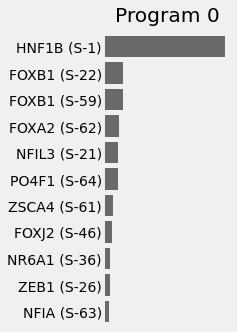

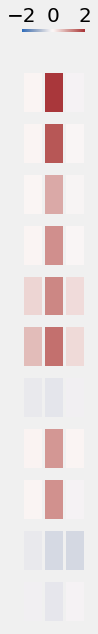

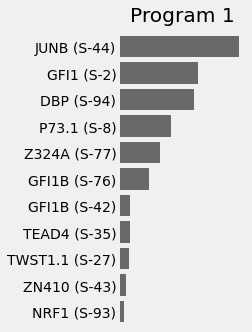

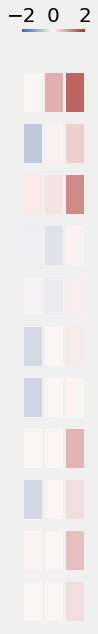

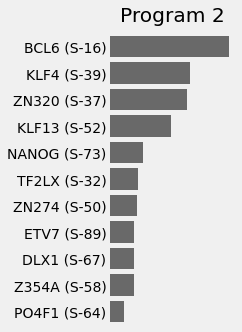

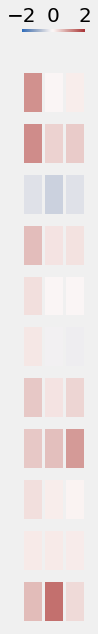

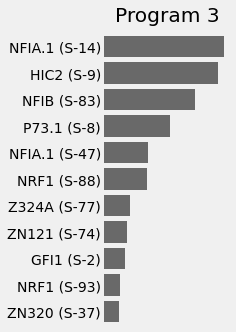

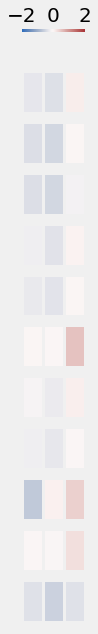

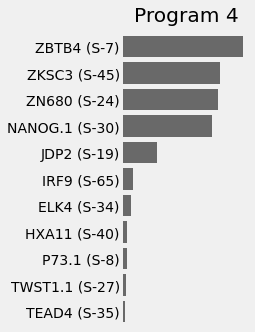

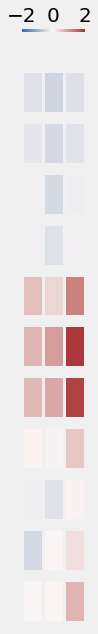

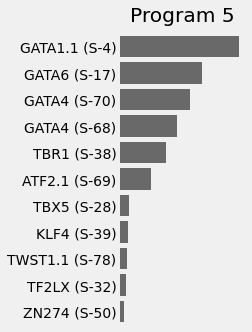

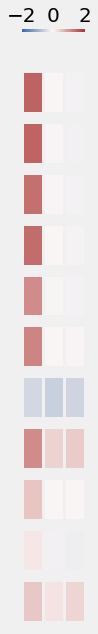

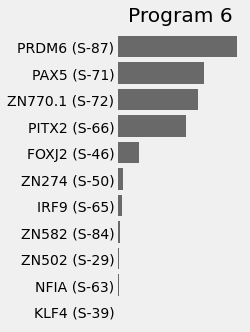

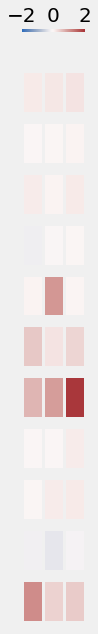

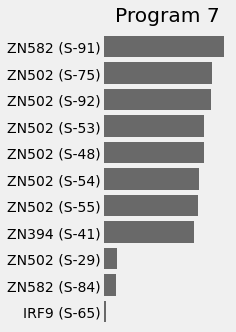

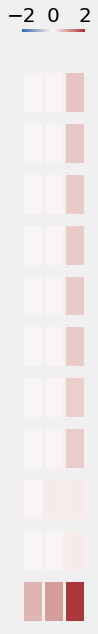

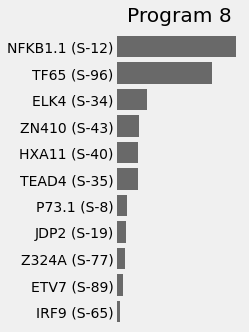

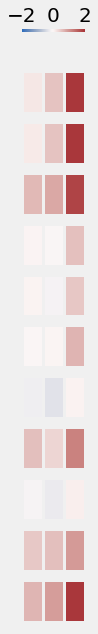

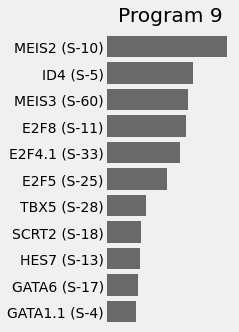

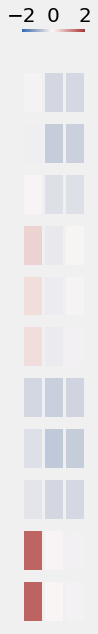

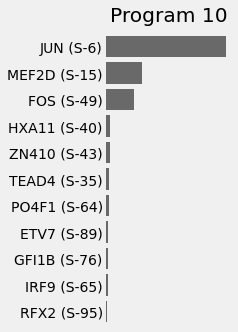

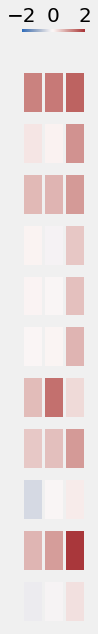

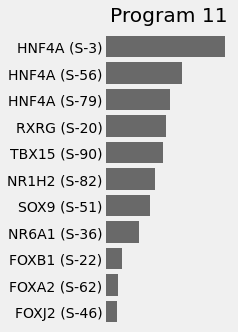

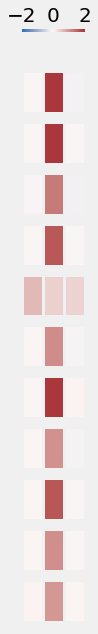

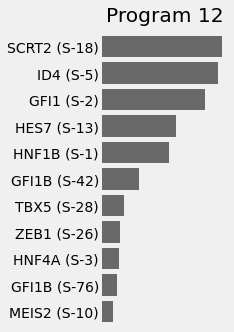

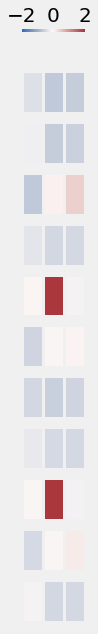

In [9]:
contrib_columns = ['contribution_K562', 'contribution_HepG2', 'contribution_SKNSH']

for i in range(13):
    values_to_sort = programs[str(i)].values
    weights = np.sort(values_to_sort)[-11:]
    labels = boda2_streme_tfs.loc[np.argsort(values_to_sort)]['motif_id'].tolist()[-11:]
    short_labels = boda2_streme_tfs.loc[np.argsort(values_to_sort)]['Target_ID_short'].tolist()[-11:]
    
    label_contributions = []
    for label in reversed(labels):
        label_contributions.append(boda2_streme_tfs[boda2_streme_tfs['motif_id'] == label][contrib_columns].to_numpy())
    label_contributions = np.concatenate(label_contributions)
    
    with plt.style.context('fivethirtyeight'):
        plt.figure(figsize=(2,5))
        #plt.barh(labels, weights, tick_label=short_labels, color='dimgray')
        g = sns.barplot(y=labels, x=np.flip(weights), color='dimgray')
        g.set_yticklabels(labels=reversed(short_labels), rotation=0)
        plt.xticks([])
        plt.box(False)
        plt.grid(False)
        plt.title(f'Program {i}', y=1.02)
        plt.show()
        
        plt.figure(figsize=(1,12))
        g = sns.heatmap(label_contributions, cmap="vlag", vmin=-2, vmax=2, #cbar=False)#, 
                        cbar_kws = dict(use_gridspec=False, location="top", shrink=1.0))
        cbar = g.collections[0].colorbar
        cbar.ax.tick_params(labelsize=20)
        
        for i in range(len(labels) + 1):
            g.axhline(i, color='#f0f0f0', lw=12)
        for i in range(3 + 1):
            g.axvline(i, color='#f0f0f0', lw=3)
        g.set_yticklabels(labels=reversed(short_labels), rotation=0)
        #g.yaxis.tick_right()
        plt.xticks([])
        plt.yticks([])
        #plt.title(' ')
        plt.show()

In [10]:
index2name = { i: v for i, v in zip(
    [7,5,9,12,1,10,3,4,8,6,2,0,11],
    ['Extra_E', 'K562_A', 'K562_B', 'HepG2_C', 'Extra_A', 'Extra_F', 'SKNSH_A', 'Extra_C', 'SKNSH_B', 'Extra_D', 'Extra_B', 'HepG2_A', 'HepG2_B'],
) }

index2color = { i: c for i, c in zip(
    range(13),
    ['#993404', '#fddaec', '#fed9a6', '#D500FF', '#ccebc5', '#253494', '#ffffcc', '#e5d8bd', '#FF0004', '#41b6c4', '#decbe4', '#d95f0e', '#fe9929']
) }

for i in range(13):
    print(i, index2name[i], index2color[i])

0 HepG2_A #993404
1 Extra_A #fddaec
2 Extra_B #fed9a6
3 SKNSH_A #D500FF
4 Extra_C #ccebc5
5 K562_A #253494
6 Extra_D #ffffcc
7 Extra_E #e5d8bd
8 SKNSH_B #FF0004
9 K562_B #41b6c4
10 Extra_F #decbe4
11 HepG2_B #d95f0e
12 HepG2_C #fe9929


In [11]:
merged_tf_df = boda2_streme_tfs.merge(programs, on='motif_id').reset_index(drop=True)

In [12]:
merged_tf_df.at[0, 'contribution_HepG2'] = merged_tf_df.iloc[0]['contribution_HepG2'] / 2

No handles with labels found to put in legend.


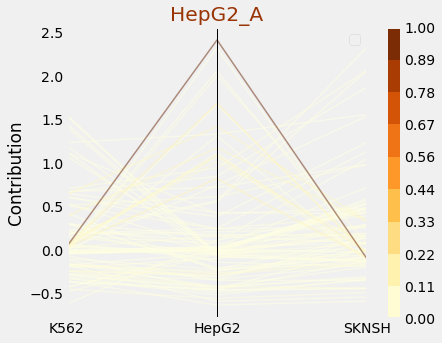

No handles with labels found to put in legend.


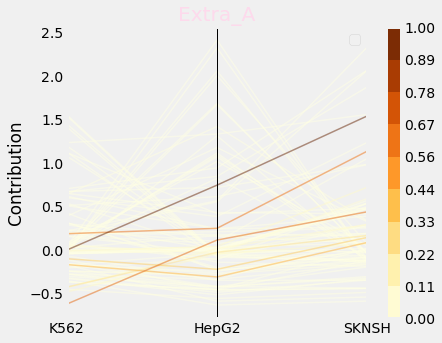

No handles with labels found to put in legend.


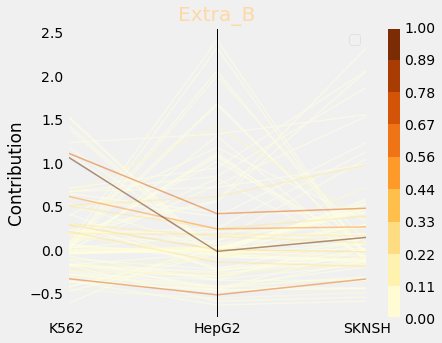

No handles with labels found to put in legend.


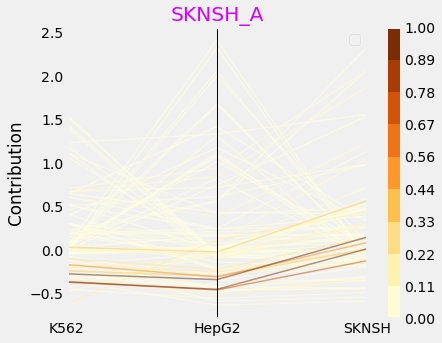

No handles with labels found to put in legend.


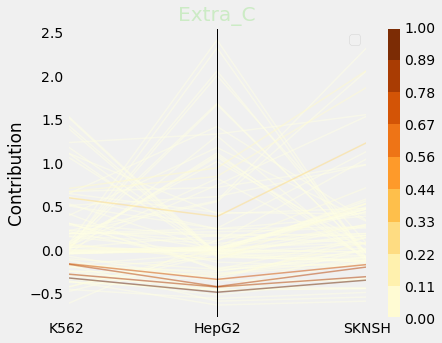

No handles with labels found to put in legend.


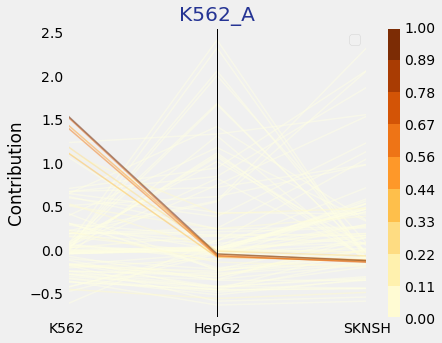

No handles with labels found to put in legend.


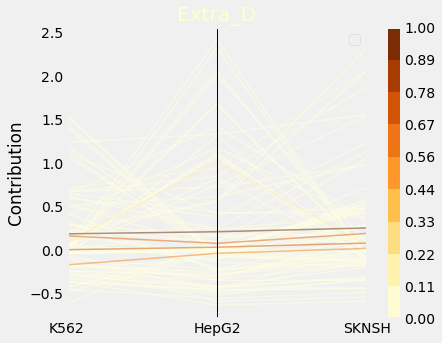

No handles with labels found to put in legend.


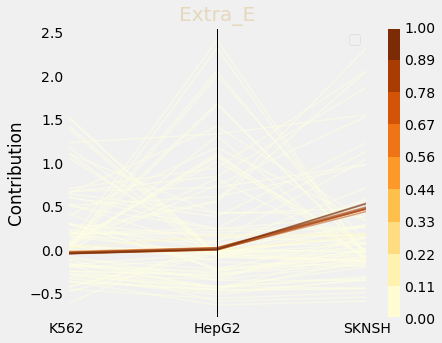

No handles with labels found to put in legend.


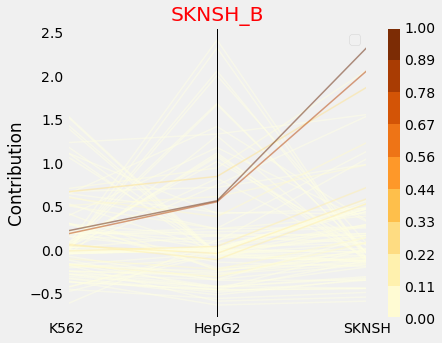

No handles with labels found to put in legend.


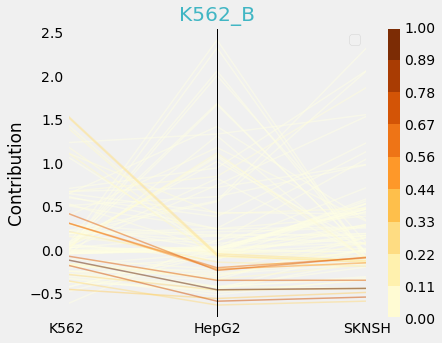

No handles with labels found to put in legend.


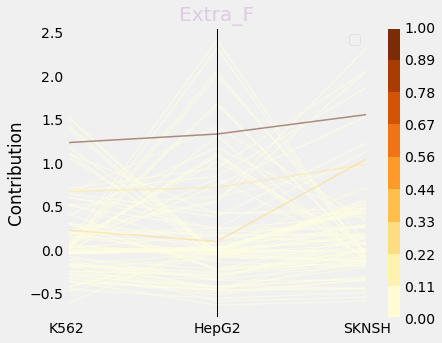

No handles with labels found to put in legend.


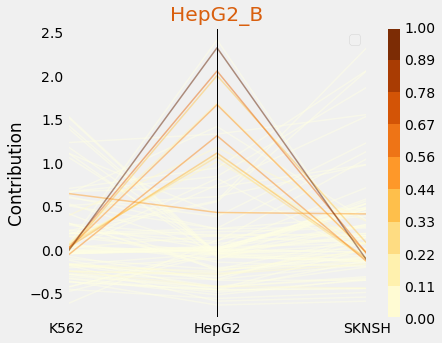

No handles with labels found to put in legend.


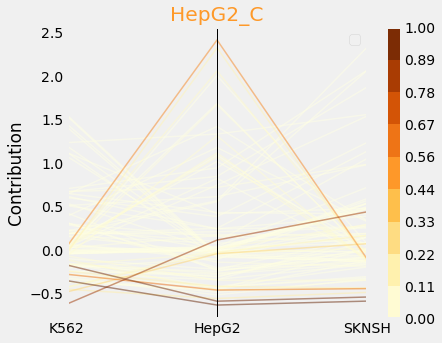

In [391]:
for program_idx in range(13):
    plot_columns = contrib_columns + [str(program_idx)]

    plot_df = merged_tf_df[plot_columns]
    plot_df = plot_df.sort_values(by=str(program_idx))

    with plt.style.context('fivethirtyeight'):    
        fig, ax = parallel_coordinates(plot_df, str(program_idx), colormap="YlOrBr", alpha=0.5, linewidth=1.5) 
        fig.set_size_inches(6, 5)
        ax.set_xticklabels(['K562', 'HepG2', 'SKNSH'])
        ax.set_ylabel('Contribution')
        ax.set_title(f'{index2name[program_idx]}', color=f'{index2color[program_idx]}')
        plt.show()

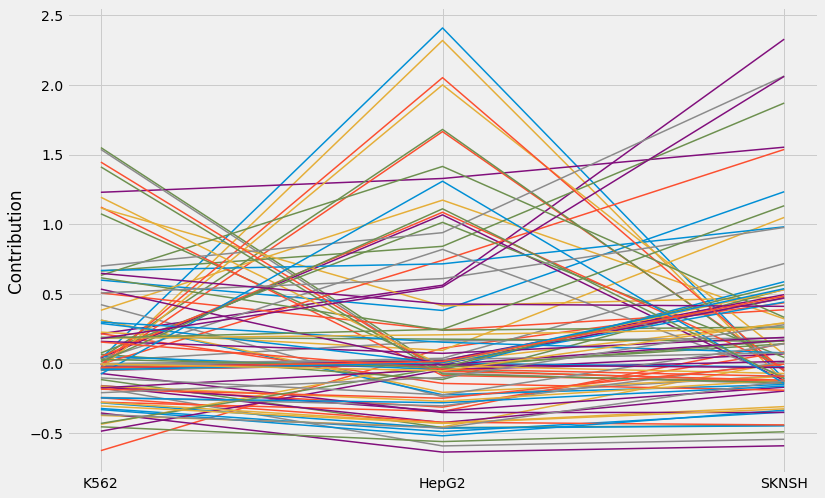

In [392]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(12,8))
    plt.plot(merged_tf_df[contrib_columns].to_numpy().T, lw=1.5)
    plt.xticks([0,1,2], labels=['K562', 'HepG2', 'SKNSH'])
    plt.ylabel('Contribution')
    plt.show()

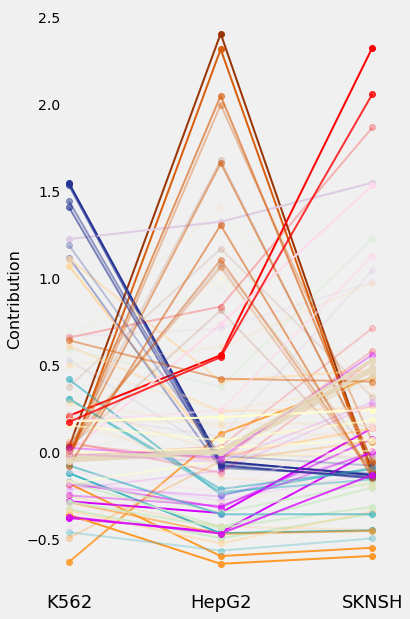

In [404]:
program_columns = [str(i) for i in range(13)]
colors = [index2color[int(idx)] for idx in merged_tf_df[program_columns].idxmax(axis=1).tolist()]
alphas = np.array(merged_tf_df[program_columns].max(axis=1).tolist())
alphas = alphas / alphas.max()

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(5,10))
    for i in range(len(merged_tf_df)):
        plt.plot(merged_tf_df.iloc[i][contrib_columns], color=colors[i], alpha=alphas[i],
                 lw=2, linestyle='-', marker='o')
    plt.xticks([0,1,2], labels=['K562', 'HepG2', 'SKNSH'], fontsize=18)
    plt.ylabel('Contribution', fontsize=16)
    plt.xlim(-0.035, 2.03)
    plt.grid(False)
    plt.show()

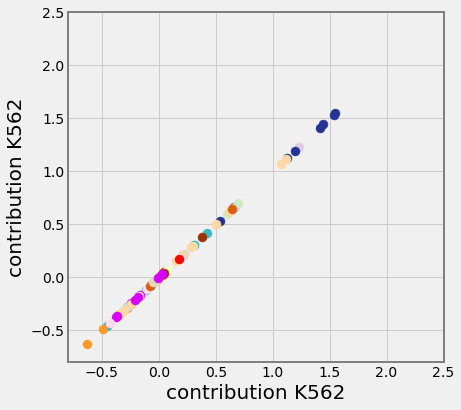

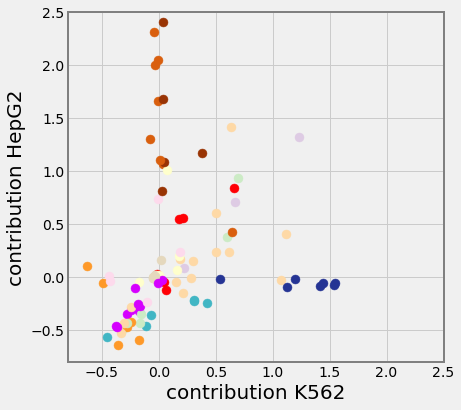

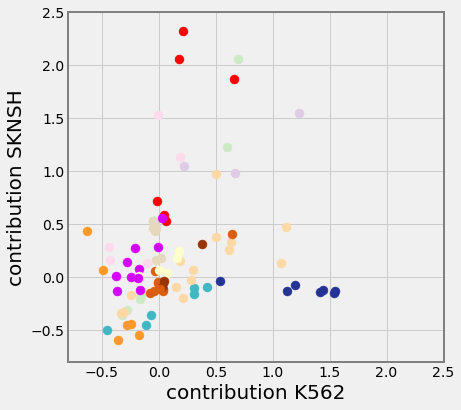

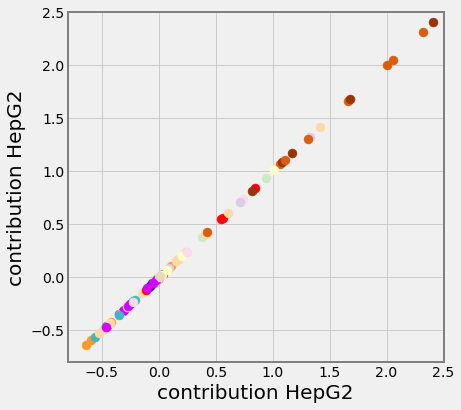

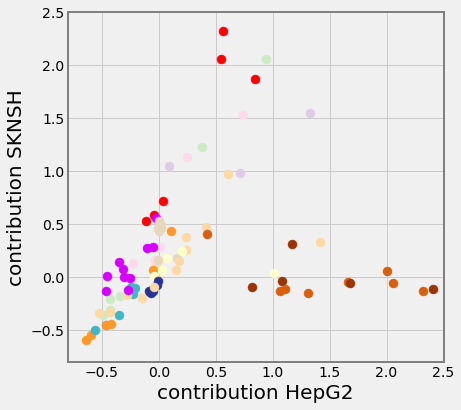

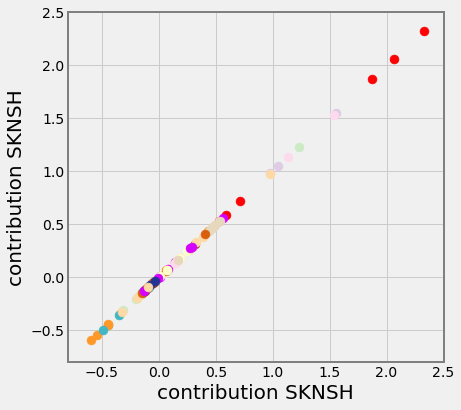

In [450]:
spine_color = 'gray'
spine_width = 2

with plt.style.context('fivethirtyeight'):
    for j in range(3):
        for k in range(j, 3):
            x_column = contrib_columns[j]
            y_column = contrib_columns[k]
            fig, ax = plt.subplots(figsize=(6, 6))
            for i in range(len(merged_tf_df)):
                ax.scatter(data=merged_tf_df.iloc[i], x=x_column, y=y_column, 
                           color=colors[i], marker='o', s=80)#, alpha=alphas[i])
            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(spine_width)
                ax.spines[axis].set_color(spine_color)
            plt.xlabel(' '.join(x_column.split('_')), fontsize=20)
            plt.ylabel(' '.join(y_column.split('_')), fontsize=20)
            plt.xlim(-0.8, 2.5)
            plt.ylim(-0.8, 2.5)
            plt.show()

# Boxen plots

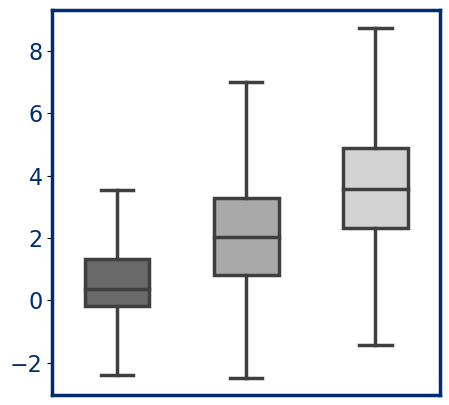

In [6]:
cell_types = ['K562', 'HepG2', 'SKNSH']
target_cells = ['k562', 'hepg2', 'sknsh']
l2fc_columns = [f'{cell_type}_signal' for cell_type in cell_types]
#l2fc_columns = [f'{cell_type}_pred_aggreg' for cell_type in cell_types]
colors = ['dimgray', 'darkgray', 'lightgrey' ]

# all_methods = ['DHS', 'gs', 'al', 'sa', 'fsp']
# row_filter = (boda2_df['method'].isin(all_methods)) #& (boda2_df['round'] == 0)
# plot_df = boda2_df[row_filter].copy()
plot_df = boda2_df.copy()

dhs_rows = plot_df['method'].isin(['DHS'])
plot_df.loc[dhs_rows, 'origin_tag'] = 'DHS'

gs_rows = plot_df['method'].isin(['gs'])
plot_df.loc[gs_rows, 'origin_tag'] = 'Genome scan'

# synth_penalized = plot_df['method'].isin(['fsp']) & (plot_df['round'] != 0)
# #synth_penalized = plot_df['method'].isin(['sa_rep'])                                       #Compare sa_rep
# plot_df.loc[synth_penalized, 'origin_tag'] = 'Synthetic (penalized)'

synth_non_penalized = plot_df['method'].isin(['al', 'sa', 'fsp']) & (plot_df['round'] == 0)
#synth_non_penalized = plot_df['method'].isin(['sa'])                                        #Compare sa_rep
plot_df.loc[synth_non_penalized, 'origin_tag'] = 'Synthetic'

order = ['DHS', 'Genome scan', 'Synthetic']
#order = ['DHS', 'Genome scan', 'Synthetic (penalized)', 'Synthetic']
quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
plot_df = plot_df[quality_filter].reset_index(drop=True)
#with plt.style.context('fivethirtyeight'):
with plt.style.context('default'):
    mpl.rc('axes',edgecolor='#002D72')
    mpl.rcParams['lines.linewidth'] = 2.5
    plt.figure(figsize=(5,5))
    g = sns.boxplot(data=plot_df, x='origin_tag', y=f'OverMax', #k_depth='full',
                  order=order, palette=colors, width=0.5,
                  showfliers=False,
                 )
    g.set(xticklabels=[])
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(fontsize=16, color='#002D72')
    for _,s in g.spines.items():
        s.set_linewidth(2.5)
        s.set_color('#002D72')
    #plt.ylim(-6.5, 9)
    #plt.ylabel("MinGap", labelpad=10, fontsize=18)
    #plt.title('Cell specificity by proposal strategy', fontsize=18, y=1.05)
    #plt.xlabel("", labelpad=10)
    #g.set_xticklabels(['DHS-natural', 'Malinois-natural', 'Synthetic'], fontsize=16)
    #g.set_xticklabels(['DHS', 'Genome scan', 'Synthetic\n(penalized)', 'Synthetic'], fontsize=16)
    #g.set_xticklabels(['DHS', 'Genome scan', 'SA (rep)', 'SA'], fontsize=16)                   #Compare sa_rep
    plt.xticks(rotation=50)
    plt.show()

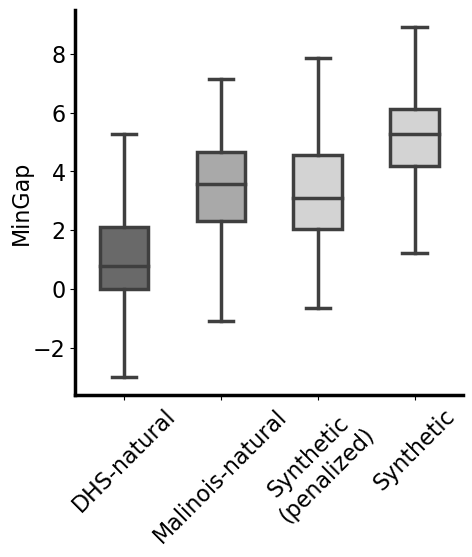

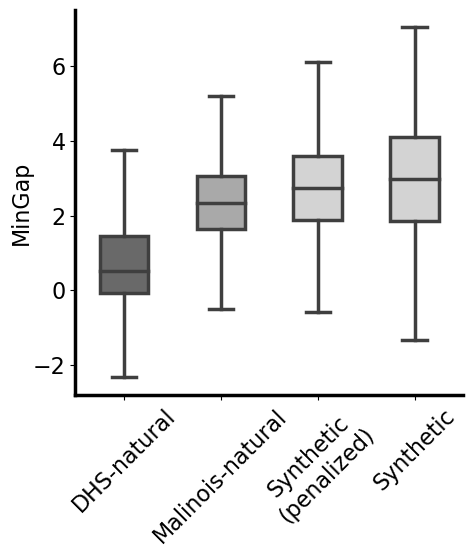

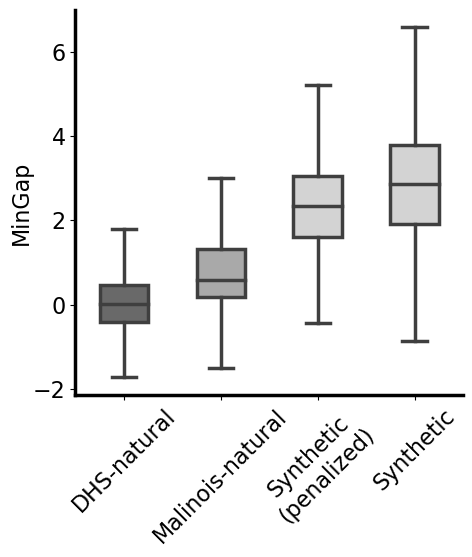

In [7]:
cell_types = ['K562', 'HepG2', 'SKNSH']
target_cells = ['k562', 'hepg2', 'sknsh']
l2fc_columns = [f'{cell_type}_signal' for cell_type in cell_types]
#l2fc_columns = [f'{cell_type}_pred_aggreg' for cell_type in cell_types]
colors = ['dimgray', 'darkgray', 'lightgrey', 'lightgrey' ]

# all_methods = ['DHS', 'gs', 'al', 'sa', 'fsp']
# row_filter = (boda2_df['method'].isin(all_methods)) #& (boda2_df['round'] == 0)
# plot_df = boda2_df[row_filter].copy()
plot_df = boda2_df.copy()

dhs_rows = plot_df['method'].isin(['DHS'])
plot_df.loc[dhs_rows, 'origin_tag'] = 'DHS'

gs_rows = plot_df['method'].isin(['gs'])
plot_df.loc[gs_rows, 'origin_tag'] = 'Genome scan'

synth_penalized = plot_df['method'].isin(['fsp']) & (plot_df['round'] != 0)
#synth_penalized = plot_df['method'].isin(['sa_rep'])                                       #Compare sa_rep
plot_df.loc[synth_penalized, 'origin_tag'] = 'Synthetic (penalized)'

synth_non_penalized = plot_df['method'].isin(['al', 'sa', 'fsp']) & (plot_df['round'] == 0)
#synth_non_penalized = plot_df['method'].isin(['sa'])                                        #Compare sa_rep
plot_df.loc[synth_non_penalized, 'origin_tag'] = 'Synthetic'

#order = ['DHS', 'Genome scan', 'Synthetic']
order = ['DHS', 'Genome scan', 'Synthetic (penalized)', 'Synthetic']
quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
plot_df = plot_df[quality_filter].reset_index(drop=True)

for target_cell in target_cells:
    temp_plot_df = plot_df[plot_df['target_cell'] == target_cell].reset_index(drop=True)
    with plt.style.context('fast'):
        #mpl.rc('axes',edgecolor='#002D72')
        mpl.rcParams['lines.linewidth'] = 2.5
        plt.figure(figsize=(5,5))
        g = sns.boxplot(data=temp_plot_df, x='origin_tag', y=f'OverMax', #k_depth='full',
                      order=order, palette=colors, width=0.5,
                      showfliers=False,
                     )
        #g.set(xticklabels=[])
        plt.xlabel('')
        #plt.xticks([])
        #plt.ylabel('')
        plt.yticks(fontsize=16)#, color='#002D72')
        for _,s in g.spines.items():
            s.set_linewidth(2.5)
            #s.set_color('#002D72')
        #plt.ylim(-6.5, 9)
        plt.ylabel("MinGap", labelpad=0, fontsize=16)
        #plt.title('Cell specificity by proposal strategy', fontsize=18, y=1.05)
        #plt.xlabel("", labelpad=10)
        #g.set_xticklabels(['DHS-natural', 'Malinois-natural', 'Synthetic'], fontsize=16)
        g.set_xticklabels(['DHS-natural', 'Malinois-natural', 'Synthetic\n(penalized)', 'Synthetic'], fontsize=16, rotation=45)
        #g.set_xticklabels(['DHS', 'Genome scan', 'SA (rep)', 'SA'], fontsize=16)                   #Compare sa_rep
        #plt.xticks(rotation=50)
        g.spines['top'].set_visible(False)
        g.spines['right'].set_visible(False)
        #g.spines['left'].set_visible(False)
        
        savepath = f'./figures/mingap_boxplots__target_{target_cell}_v3.pdf'
        #plt.savefig(savepath, format='pdf', transparent=True, dpi=150, bbox_inches='tight')
        plt.show()

In [8]:
group_1 = 'Genome scan'
group_2 = 'DHS'
for target_cell in target_cells:
    temp_plot_df = plot_df[plot_df['target_cell'] == target_cell].reset_index(drop=True)
    dist_1 = temp_plot_df[temp_plot_df['origin_tag'] == group_1]['OverMax']
    dist_2 = temp_plot_df[temp_plot_df['origin_tag'] == group_2]['OverMax']
    median_1 = dist_1.median()
    median_2 = dist_2.median()
    print(median_1, median_2)
    print(median_1 - median_2)
    print(stats.ranksums(dist_1.to_numpy(), dist_2.to_numpy(), alternative='greater'))
    print('')
    
group_1 = 'Synthetic'
group_2 = 'Genome scan'
for target_cell in target_cells:
    temp_plot_df = plot_df[plot_df['target_cell'] == target_cell].reset_index(drop=True)
    dist_1 = temp_plot_df[temp_plot_df['origin_tag'] == group_1]['OverMax']
    dist_2 = temp_plot_df[temp_plot_df['origin_tag'] == group_2]['OverMax']
    median_1 = dist_1.median()
    median_2 = dist_2.median()
    print(median_1, median_2)
    print(median_1 - median_2)
    print(stats.ranksums(dist_1.to_numpy(), dist_2.to_numpy(), alternative='greater'))
    print('')

3.5658938080774853 0.7878141082735228
2.7780796998039623
RanksumsResult(statistic=49.30965095686951, pvalue=0.0)

2.3428041985985493 0.5059779388355405
1.8368262597630087
RanksumsResult(statistic=51.83261129269432, pvalue=0.0)

0.5885382073937303 0.020384349545533
0.5681538578481973
RanksumsResult(statistic=34.312830142052384, pvalue=2.5256346691780976e-258)

5.2648744143046775 3.5658938080774853
1.6989806062271922
RanksumsResult(statistic=48.26595549698985, pvalue=0.0)

2.988343604560169 2.3428041985985493
0.6455394059616197
RanksumsResult(statistic=23.394100372773206, pvalue=2.453679638080772e-121)

2.866787736703759 0.5885382073937303
2.2782495293100284
RanksumsResult(statistic=70.44389637174685, pvalue=0.0)



In [10]:
group_1 = 'Genome scan'
group_2 = 'DHS'
for target_cell in target_cells:
    temp_plot_df = plot_df[plot_df['target_cell'] == target_cell].reset_index(drop=True)
    dist_1 = temp_plot_df[temp_plot_df['origin_tag'] == group_1]['OverMax']
    dist_2 = temp_plot_df[temp_plot_df['origin_tag'] == group_2]['OverMax']
    median_1 = dist_1.median()
    median_2 = dist_2.median()
    print(median_1, median_2)
    print(median_1 - median_2)
    print(stats.ranksums(dist_1.to_numpy(), dist_2.to_numpy()))
    print('')
    
group_1 = 'Synthetic'
group_2 = 'Genome scan'
for target_cell in target_cells:
    temp_plot_df = plot_df[plot_df['target_cell'] == target_cell].reset_index(drop=True)
    dist_1 = temp_plot_df[temp_plot_df['origin_tag'] == group_1]['OverMax']
    dist_2 = temp_plot_df[temp_plot_df['origin_tag'] == group_2]['OverMax']
    median_1 = dist_1.median()
    median_2 = dist_2.median()
    print(median_1, median_2)
    print(median_1 - median_2)
    print(stats.ranksums(dist_1.to_numpy(), dist_2.to_numpy()))
    print('')

3.565893808077485 0.7878141082735228
2.7780796998039623
RanksumsResult(statistic=49.30965095686951, pvalue=0.0)

2.3428041985985493 0.5059779388355405
1.8368262597630087
RanksumsResult(statistic=51.83261129269432, pvalue=0.0)

0.5885382073937303 0.020384349545533
0.5681538578481973
RanksumsResult(statistic=34.312830142052384, pvalue=5.051269338356195e-258)

5.2648744143046775 3.565893808077485
1.6989806062271926
RanksumsResult(statistic=48.26595549698985, pvalue=0.0)

2.988343604560169 2.3428041985985493
0.6455394059616197
RanksumsResult(statistic=23.394100372773206, pvalue=4.907359276161544e-121)

2.866787736703759 0.5885382073937303
2.2782495293100284
RanksumsResult(statistic=70.44389637174685, pvalue=0.0)



In [14]:
color_dict = {
  'penalized': '#FFB2E6',
  'gradient': '#FFB2E6',
  'probabilistic': '#D972FF',
  'evolutionary': '#8447FF',
  'Malinois_natural': '#33D15B',
  'DHS_natural': '#57954A',
  'all_naturals': '#5B9EDD',
  'all_synthetics': '#FF6D79',
}

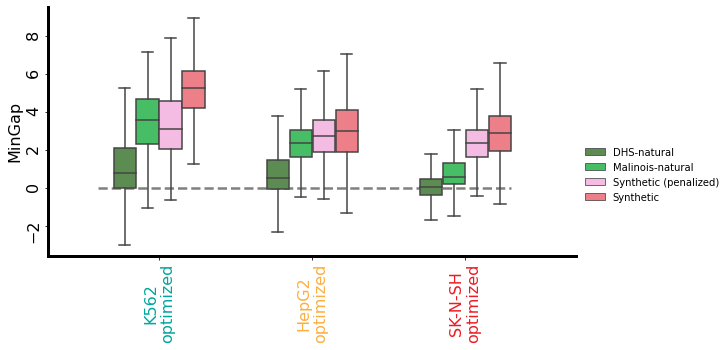

In [91]:
#colors = ['#00A79D', '#FBB040', '#ED1C24']
colors = [color_dict['DHS_natural'], color_dict['Malinois_natural'], color_dict['gradient'], color_dict['all_synthetics']]
hatches = ['', '', '.', '']

aspect = 2
height = 4
width = 0.6
linewidth = 2.5
axes_linewidth = 3
ytick_fontsize = 16

with plt.style.context('fast'):
    mpl.rcParams['lines.linewidth'] = linewidth
    g = sns.catplot(data=plot_df, x='target_cell', y='OverMax', hue='origin_tag', kind='box',
                    palette=colors, showfliers=False, order=target_cells, hue_order=order,
                   aspect=aspect, width=width, height=height, legend=True, linewidth = 1.5)
    plt.hlines(0,-0.4,2.3, zorder=0, linestyle='dashed', color='grey')
    for ax in g.axes.flat:
        patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
        h = hatches * (len(patches) // len(hatches))
        for patch, hatch in zip(patches, h):
            patch.set_hatch(hatch)
    for spine in plt.gca().spines.values():
        spine.set_linewidth(axes_linewidth)
    #plt.title(f'K562 target', y=title_y, color='#002D72')
    g.set(xticklabels=[])
    plt.xlabel('')
    #plt.xticks([])
    #g.set_xticklabels(['DHS-natural', 'Malinois-natural', 'Synthetic\n(penalized)', 'Synthetic'], fontsize=16, rotation=90)
    g.set_xticklabels(['K562\noptimized', 'HepG2\noptimized', 'SK-N-SH\noptimized'], fontsize=16, rotation=90)
    plt.ylabel('MinGap', fontsize=ytick_fontsize)
    #plt.ylabel('log2FC', fontsize=14, color='#002D72')
    plt.yticks(fontsize=ytick_fontsize, rotation=90)#, color='#002D72')
    for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), ['#00A79D', '#FBB040', '#ED1C24']):
        ticklabel.set_color(tickcolor)
    g._legend.set_title('')
    new_labels = ['DHS-natural', 'Malinois-natural', 'Synthetic (penalized)', 'Synthetic']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    plt.margins(x=0)
    #savepath = f'./figures/l2fc_boxplots__target_{target_cell}_v2.pdf'
    savepath = f'./figures/mingap_all_boxplots.pdf'
    plt.savefig(savepath, format='pdf', transparent=True, dpi=150, bbox_inches='tight')

#     plt.ylim(-3, 9.5)
    plt.show()

In [59]:
#colors = ['#00A79D', '#FBB040', '#ED1C24']
colors = ['lightgrey', 'darkgray', 'dimgray']
temp_df = plot_df.copy() #[[*l2fc_columns, 'origin_tag', 'target_cell']]

# sns.catplot(data=temp_df, x='target_cell', y=l2fc_columns[0], hue='origin_tag', kind="boxen",
#             palette=reversed(colors), showfliers=False, hue_order=['Synthetic', 'Genome scan', 'DHS'], order=target_cells,
#            aspect=1.5)
# plt.show()

In [60]:
temp_df2 = temp_df[l2fc_columns].stack().reset_index()
temp_df2['origin_tag'] = temp_df2.progress_apply(lambda x: temp_df.iloc[int(x['level_0'])]['origin_tag'], axis=1)
temp_df2['target_cell'] = temp_df2.progress_apply(lambda x: temp_df.iloc[int(x['level_0'])]['target_cell'], axis=1)

temp_df2

  0%|          | 0/336561 [00:00<?, ?it/s]

  0%|          | 0/336561 [00:00<?, ?it/s]

,level_0,level_1,0,origin_tag,target_cell
0,0,K562_signal,2.520816,NaN,hepg2
1,0,HepG2_signal,5.287727,NaN,hepg2
2,0,SKNSH_signal,0.605723,NaN,hepg2
3,1,K562_signal,0.609272,NaN,hepg2
4,1,HepG2_signal,6.402153,NaN,hepg2
...,...,...,...,...,...
336556,112185,HepG2_signal,-0.014411,NaN,NaN
336557,112185,SKNSH_signal,0.239693,NaN,NaN
336558,112186,K562_signal,0.107924,NaN,NaN
336559,112186,HepG2_signal,0.306959,NaN,NaN


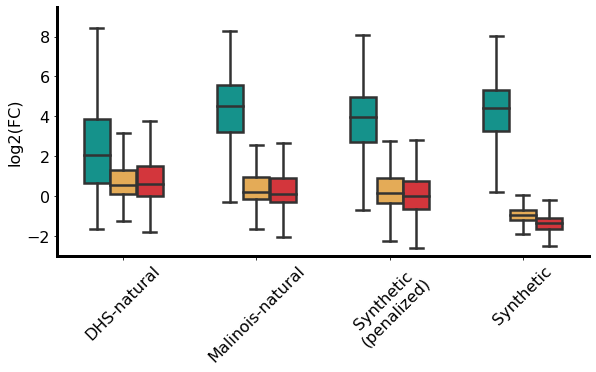

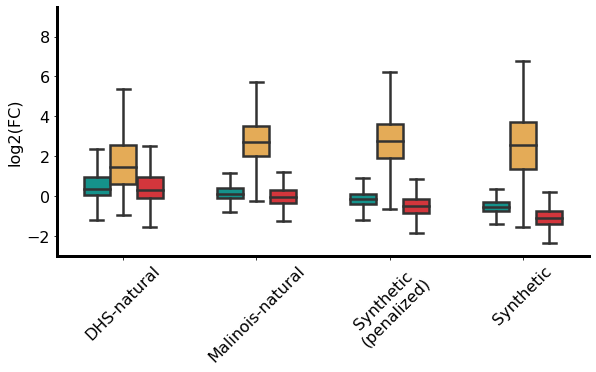

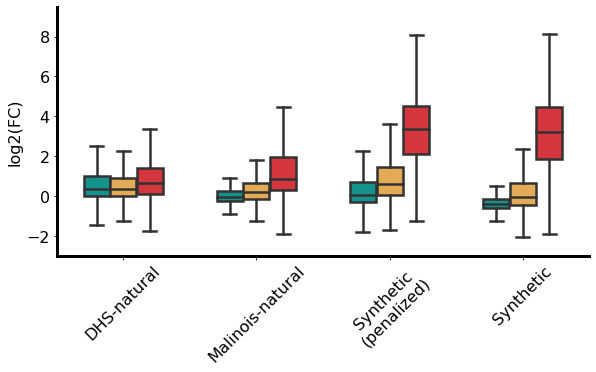

In [61]:
colors = ['#00A79D', '#FBB040', '#ED1C24']
styles = ['ggplot', 'fivethirtyeight', 'fast', 'dark_background']
aspect = 2
height = 4
width = 0.6
linewidth = 2.5
kind = 'box'
title_y = 1.00
axes_linewidth = 3
ytick_fontsize = 16

#order = ['DHS', 'Genome scan', 'Synthetic']
order = ['DHS', 'Genome scan', 'Synthetic (penalized)', 'Synthetic']

style = styles[2]

#for target_cell in target_cells:
target_cell = target_cells[0]
plot_df = temp_df2[temp_df2['target_cell'] == target_cell]
with plt.style.context(style):
    #mpl.rc('axes',edgecolor='#002D72')
    mpl.rcParams['lines.linewidth'] = linewidth
    g = sns.catplot(data=plot_df, x='origin_tag', y=0, hue='level_1', kind=kind,
                palette=colors, showfliers=False, order=order,
               aspect=aspect, width=width, height=height, legend=False)
    for spine in plt.gca().spines.values():
        spine.set_linewidth(axes_linewidth)
    #plt.title(f'K562 target', y=title_y, color='#002D72')
    g.set(xticklabels=[])
    plt.xlabel('')
    #plt.xticks([])
    g.set_xticklabels(['DHS-natural', 'Malinois-natural', 'Synthetic\n(penalized)', 'Synthetic'], fontsize=16, rotation=45)
    plt.ylabel('log2(FC)', fontsize=ytick_fontsize)
    #plt.ylabel('log2FC', fontsize=14, color='#002D72')
    plt.yticks(fontsize=ytick_fontsize)#, color='#002D72')
    savepath = f'./figures/l2fc_boxplots__target_{target_cell}_v2.pdf'
    #savepath = f'./figures/pred_boxplots__target_{target_cell}_v2.pdf'
    plt.savefig(savepath, format='pdf', transparent=True, dpi=150, bbox_inches='tight')
    
    plt.ylim(-3, 9.5)
    plt.show()
    
target_cell = target_cells[1]
plot_df = temp_df2[temp_df2['target_cell'] == target_cell]
with plt.style.context(style):
    #mpl.rc('axes',edgecolor='#002D72')
    mpl.rcParams['lines.linewidth'] = linewidth
    g = sns.catplot(data=plot_df, x='origin_tag', y=0, hue='level_1', kind=kind,
                palette=colors, showfliers=False, order=order,
               aspect=aspect, width=width, height=height, legend=False)
    for spine in plt.gca().spines.values():
        spine.set_linewidth(axes_linewidth)
    #plt.title(f'HepG2 target', y=title_y, color='#002D72')
    #g.set(yticklabels=[])
    g.set(xticklabels=[])
    plt.xlabel('')
    #plt.xticks([])
    g.set_xticklabels(['DHS-natural', 'Malinois-natural', 'Synthetic\n(penalized)', 'Synthetic'], fontsize=16, rotation=45)
    plt.ylabel('log2(FC)', fontsize=ytick_fontsize)
    #plt.ylabel('log2FC', fontsize=14, color='#002D72')
    plt.yticks(fontsize=ytick_fontsize)#, color='#002D72')
    savepath = f'./figures/l2fc_boxplots__target_{target_cell}_v2.pdf'
    #savepath = f'./figures/pred_boxplots__target_{target_cell}_v2.pdf'
    plt.savefig(savepath, format='pdf', transparent=True, dpi=150, bbox_inches='tight')
    plt.ylim(-3, 9.5)
    plt.show()
    
target_cell = target_cells[2]
plot_df = temp_df2[temp_df2['target_cell'] == target_cell]
with plt.style.context(style):
    #mpl.rc('axes',edgecolor='#002D72')
    mpl.rcParams['lines.linewidth'] = linewidth
    g = sns.catplot(data=plot_df, x='origin_tag', y=0, hue='level_1', kind=kind,
                palette=colors, showfliers=False, order=order,
               aspect=aspect, width=width, height=height, legend=False)
    for spine in plt.gca().spines.values():
        spine.set_linewidth(axes_linewidth)
    #plt.title(f'SKNSH target', y=title_y, color='#002D72')
    #g.set(yticklabels=[])
    plt.xlabel('')
    #plt.xticks([])
    #g.set_xticklabels(['DHS-natural', 'Malinois-natural', 'Synthetic'], fontsize=16, rotation=45, color='#002D72')
    g.set_xticklabels(['DHS-natural', 'Malinois-natural', 'Synthetic\n(penalized)', 'Synthetic'], fontsize=16, rotation=45)
    #g.set_xticklabels(['DHS', 'Genome scan', 'SA (rep)', 'SA'], fontsize=16, rotation=45)                          #Compare sa_rep
    plt.ylabel('log2(FC)', fontsize=ytick_fontsize)
    plt.yticks(fontsize=ytick_fontsize)#, color='#002D72')
    #plt.ylabel('log2FC', fontsize=14, color='#002D72')
    savepath = f'./figures/l2fc_boxplots__target_{target_cell}_v2.pdf'
    #savepath = f'./figures/pred_boxplots__target_{target_cell}_v2.pdf'
    plt.savefig(savepath, format='pdf', transparent=True, dpi=150, bbox_inches='tight')
    plt.ylim(-3, 9.5)
    plt.show()

In [68]:
cell = 'HepG2'
target_cell = cell.lower()
signal = f'{cell}_signal'

print(temp_df[(temp_df['origin_tag'] == 'Synthetic') & (temp_df['target_cell'] == target_cell)][signal].median())
#print(temp_df[(temp_df['origin_tag'] == 'Synthetic (penalized)') & (temp_df['target_cell'] == target_cell)][signal].median())
print(temp_df[(temp_df['origin_tag'] == 'Genome scan') & (temp_df['target_cell'] == target_cell)][signal].median())
print(temp_df[(temp_df['origin_tag'] == 'DHS') & (temp_df['target_cell'] == target_cell)][signal].median())

2.5516011382962502
2.72062177695969
1.44007910731746


In [75]:
group = 'Genome scan'

row_filter = (temp_df['target_cell'] == 'k562') & (temp_df['origin_tag'] == group)
a = temp_df[row_filter][['SKNSH_signal', 'HepG2_signal']].stack().to_numpy()
row_filter = (temp_df['target_cell'] == 'hepg2') & (temp_df['origin_tag'] == group)
b = temp_df[row_filter][['SKNSH_signal', 'K562_signal']].stack().to_numpy()

row_filter = (temp_df['target_cell'] == 'sknsh') & (temp_df['origin_tag'] == group)
c = temp_df[row_filter][['K562_signal', 'HepG2_signal']].stack().to_numpy()

print(np.median(np.concatenate([a,b,c])))

0.0870146888724235


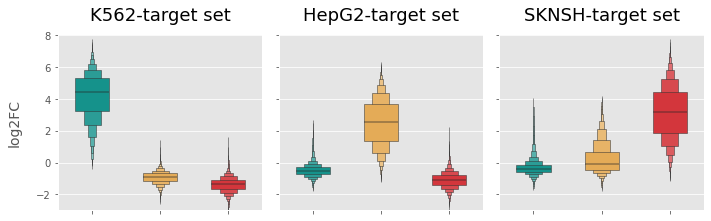

In [785]:
all_methods = ['al', 'sa', 'fsp']
cell_types = ['K562', 'HepG2', 'SKNSH']
target_cells = ['k562', 'hepg2', 'sknsh']
l2fc_columns = [f'{cell_type}_signal' for cell_type in cell_types]

row_filter = (boda2_df['method'].isin(all_methods)) & (boda2_df['round'] == 0)
plot_df = boda2_df[row_filter].copy()
quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
plot_df = plot_df[quality_filter].reset_index(drop=True)

temp_df = plot_df[[*l2fc_columns, 'target_cell']]

#colors = [(0, 1, 1), (1, 0.85, 0.1), (1, 0, 0)]
#colors = [(0, 1, 1), 'gold', (1, 0, 0)]
colors = ['#00A79D', '#FBB040', '#ED1C24']

styles = ['ggplot', 'fivethirtyeight', 'fast', 'dark_background']

with plt.style.context(styles[0]):
    g = sns.catplot(data=temp_df, col='target_cell', kind='boxen', palette=colors, col_order=target_cells,
                   showfliers=False, aspect=1, width=0.5, height=3.2, 
                   )
    
    g.set_axis_labels('', "log2FC", fontsize=14, labelpad=15)
    g.set_xticklabels(['', '', ''], fontsize=14)    
    #g.set_yticklabels([-4, -2, 0, 2, 4, 6, 8, 10], size = 14)
    g.set_titles("{col_name} target")
    #g.fig.subplots_adjust(top=10.0)
    #g.despine(left=True)
    for ax, title in zip(g.axes.flat, ['K562-target set', 'HepG2-target set', 'SKNSH-target set']):
        ax.set_title(title, fontsize=18, y=1.05)
    plt.ylim(-3, 8)
    plt.show()

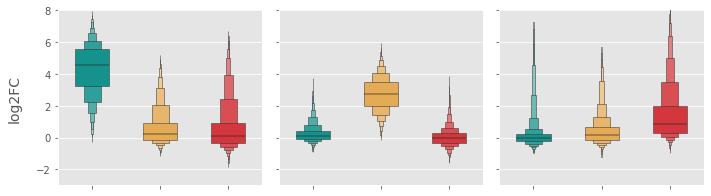

In [784]:
all_methods = ['gs']
cell_types = ['K562', 'HepG2', 'SKNSH']
target_cells = ['k562', 'hepg2', 'sknsh']
l2fc_columns = [f'{cell_type}_signal' for cell_type in cell_types]

row_filter = (boda2_df['method'].isin(all_methods)) & (boda2_df['round'] == 0)
plot_df = boda2_df[row_filter].copy()
quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
plot_df = plot_df[quality_filter].reset_index(drop=True)

temp_df = plot_df[[*l2fc_columns, 'target_cell']]

#colors = [(0, 1, 1), (1, 0.85, 0.1), (1, 0, 0)]
#colors = [(0, 1, 1), 'gold', (1, 0, 0)]
colors = ['#00A79D', '#FBB040', '#ED1C24']

styles = ['ggplot', 'fivethirtyeight', 'fast', 'dark_background']

with plt.style.context(styles[0]):
    g = sns.catplot(data=temp_df, col='target_cell', kind='boxen', palette=colors, col_order=target_cells,
                   showfliers=False, aspect=1, width=0.5, height=3.2)
    
    g.set_axis_labels('', "log2FC", fontsize=14, labelpad=15)
    g.set_xticklabels(['', '', ''], fontsize=14)    
    #g.set_yticklabels([-4, -2, 0, 2, 4, 6, 8, 10], size = 14)
    g.set_titles("{col_name} target")
    #g.fig.subplots_adjust(top=10.0)
    #g.despine(left=True)
    for ax, title in zip(g.axes.flat, ['', '', '']):
        ax.set_title(title, fontsize=18, y=1.05)
    plt.ylim(-3, 8)
    plt.show()

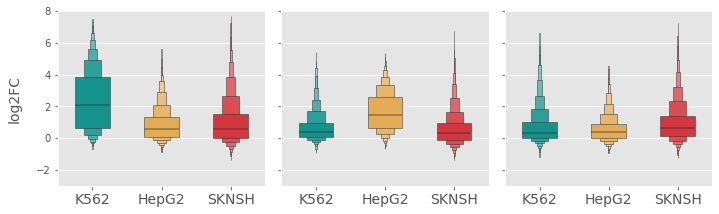

In [783]:
all_methods = ['DHS']
cell_types = ['K562', 'HepG2', 'SKNSH']
target_cells = ['k562', 'hepg2', 'sknsh']
l2fc_columns = [f'{cell_type}_signal' for cell_type in cell_types]

row_filter = (boda2_df['method'].isin(all_methods)) & (boda2_df['round'] == 0)
plot_df = boda2_df[row_filter].copy()
quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
plot_df = plot_df[quality_filter].reset_index(drop=True)

temp_df = plot_df[[*l2fc_columns, 'target_cell']]

#colors = [(0, 1, 1), (1, 0.85, 0.1), (1, 0, 0)]
#colors = [(0, 1, 1), 'gold', (1, 0, 0)]
colors = ['#00A79D', '#FBB040', '#ED1C24']

styles = ['ggplot', 'fivethirtyeight', 'fast', 'dark_background']

with plt.style.context(styles[0]):
    g = sns.catplot(data=temp_df, col='target_cell', kind='boxen', palette=colors, col_order=target_cells,
                   showfliers=False, aspect=1, width=0.5, height=3.2)
    
    #g.set_axis_labels('MPRA experiment', "log2FC", fontsize=16, labelpad=15)
    g.set_axis_labels('', "log2FC", fontsize=14, labelpad=15)
    g.set_xticklabels(['K562', 'HepG2', 'SKNSH'], fontsize=14)    
    #g.set_yticklabels([-4, -2, 0, 2, 4, 6, 8, 10], size = 14)
    g.set_titles("{col_name} target")
    #g.fig.subplots_adjust(top=10.0)
    #g.despine(left=True)
    for ax, title in zip(g.axes.flat, ['', '', '']):
        ax.set_title(title, fontsize=18, y=1.05)
    plt.ylim(-3, 8)
    plt.show()

# Admixture plots

In [97]:
programs = pd.read_table('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/STREME_topic_modeling/BODA_topics.txt',
                         sep='\t', header=0, index_col=0)
transformed_programs = pd.read_table('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/STREME_topic_modeling/BODA_transformed_topics.txt',
                                     sep='\t', header=0, index_col=0)

transformed_programs = transformed_programs.reset_index().rename({'index':'motif_id'}, axis=1)

In [98]:
#programs = programs / programs.sum(axis=0)

In [99]:
pal = sns.color_palette([index2color[i] for i in range(13)])
pal

[(0.6, 0.20392156862745098, 0.01568627450980392),
 (0.9921568627450981, 0.8549019607843137, 0.9254901960784314),
 (0.996078431372549, 0.8509803921568627, 0.6509803921568628),
 (0.8352941176470589, 0.0, 1.0),
 (0.8, 0.9215686274509803, 0.7725490196078432),
 (0.1450980392156863, 0.20392156862745098, 0.5803921568627451),
 (1.0, 1.0, 0.8),
 (0.8980392156862745, 0.8470588235294118, 0.7411764705882353),
 (1.0, 0.0, 0.01568627450980392),
 (0.2549019607843137, 0.7137254901960784, 0.7686274509803922),
 (0.8705882352941177, 0.796078431372549, 0.8941176470588236),
 (0.8509803921568627, 0.37254901960784315, 0.054901960784313725),
 (0.996078431372549, 0.6, 0.1607843137254902)]

In [100]:
program_columns = [str(i) for i in range(13)]
merged_tf_df = boda2_streme_tfs.merge(programs, on='motif_id').reset_index(drop=True)
example_df = merged_tf_df[program_columns]

In [101]:
merged_tf_df.to_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/STREME_global_analysis/streme_TFs_ultimate_merge.txt', sep=" ", index=None)

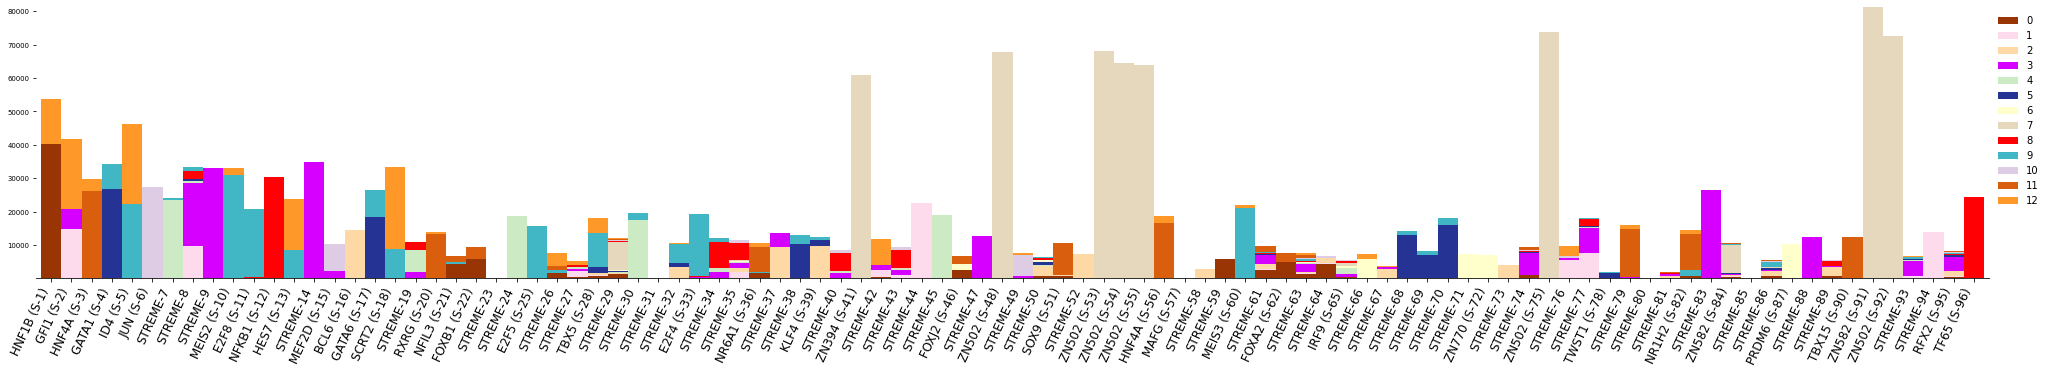

In [102]:
ax = example_df.plot.bar(stacked=True, 
                    figsize=(35,5), 
                    width=1,
                    color=pal, 
                    fontsize='x-small',
                    edgecolor='black', 
                    linewidth=0.0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticklabels(merged_tf_df['ultimate_id'].tolist(), rotation=65, ha='right', fontsize=12)
ax.legend(bbox_to_anchor=(1,1), fontsize='medium', labelspacing=0.5, frameon=False)
plt.show()

In [231]:
seq_programs = pd.read_table('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/STREME_topic_modeling/BODA_sequence_topics.txt',
                         sep='\t', header=0, index_col=0)
seq_programs = seq_programs.reset_index()
seq_programs = seq_programs.rename({'id':'ID'}, axis=1)

In [240]:
target_cell = 'k562'
method = 'fsp'

merged_seq_df = boda2_df.merge(seq_programs, on='ID', how='inner').reset_index(drop=True)
merged_seq_df = merged_seq_df[(merged_seq_df['method'] == method) & (merged_seq_df['target_cell'] == target_cell)].reset_index(drop=True)

track_info = [a[1] for a in merged_seq_df['ID'].str.split('__').tolist() ]
merged_seq_df['penalty_track'] = track_info

merged_seq_df['penalty_track'].dropna().unique()

array(['323391', '477844', '730114', '619474', '893131'], dtype=object)

In [241]:
streme_dicts = {}
for root, dirs, files in os.walk('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/fsp_streme_dicts'):
    for file_path in files:
        if target_cell in file_path:
            _, method, cell_type, track_ID, random_tag, round = file_path.split('__')
            if round != 'round_0':
                #track_info = ('__').join([track_ID, random_tag, round.rstrip('.pt')])
                track_info = random_tag + '__' + round.rstrip('.pt')
                print(file_path)
                streme_dicts[track_info] = torch.load(root + '/' + file_path)

streme_penalty__fsp__k562__20211212_085225__619474__round_2.pt
streme_penalty__fsp__k562__20211212_024754__730114__round_5.pt
streme_penalty__fsp__k562__20211212_092818__893131__round_3.pt
streme_penalty__fsp__k562__20211212_024754__730114__round_1.pt
streme_penalty__fsp__k562__20211212_085225__619474__round_3.pt
streme_penalty__fsp__k562__20211212_024754__730114__round_4.pt
streme_penalty__fsp__k562__20211212_092818__893131__round_2.pt
streme_penalty__fsp__k562__20211212_022207__477844__round_5.pt
streme_penalty__fsp__k562__20211212_022207__477844__round_1.pt
streme_penalty__fsp__k562__20211212_022207__477844__round_4.pt
streme_penalty__fsp__k562__20211212_022207__477844__round_3.pt
streme_penalty__fsp__k562__20211212_022207__477844__round_2.pt
streme_penalty__fsp__k562__20211212_024754__730114__round_3.pt
streme_penalty__fsp__k562__20211212_085225__619474__round_4.pt
streme_penalty__fsp__k562__20211212_092818__893131__round_5.pt
streme_penalty__fsp__k562__20211212_092818__893131__rou

477844 1750


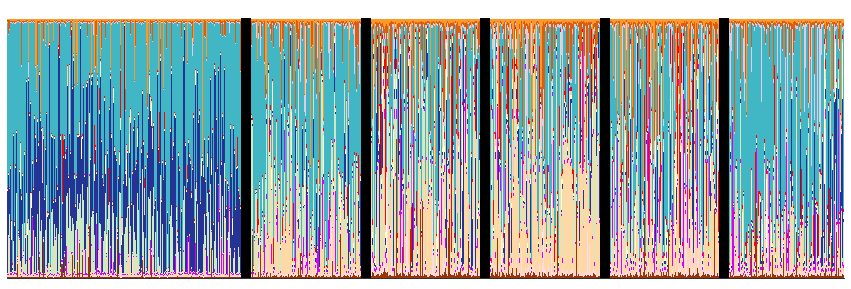

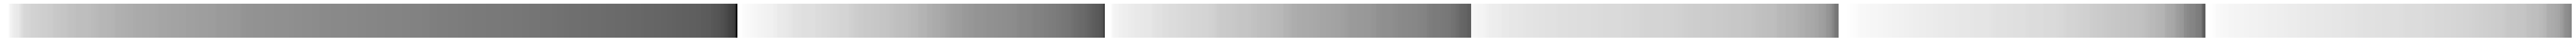

CPU times: user 30.3 s, sys: 439 ms, total: 30.8 s
Wall time: 30.9 s


In [244]:
%%time

round_ticks = [500, 750, 1000, 1250, 1500]
#round_ticks = [5, 7, 10, 12, 15]
for track_id in merged_seq_df['penalty_track'].dropna().unique():
    example_df = merged_seq_df[(merged_seq_df['penalty_track'] == track_id)].reset_index()
    example_df = example_df.sort_values(by=['round', 'OverMax'], na_position='first').reset_index(drop=True)
    if example_df['round'].max() > 0:    
        plot_df = example_df[program_columns]
        print(track_id, len(plot_df))

        ax = plot_df.plot.bar(stacked=True, 
                        figsize=(75,10), 
                        width=1,
                        color=pal, 
                        fontsize='x-small',
                        edgecolor='black', 
                        linewidth=0.0,
                        legend=False)
        for xc in round_ticks:
            ax.axvline(xc-1, 0, 0.94, color='k', linestyle='-', lw=10)
            
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
#         ax.set_xticks(round_ticks)
#         ax.set_xticklabels(labels=round_ticks, fontsize=24)     
#         ax.legend(bbox_to_anchor=(1,0.5), fontsize='medium', labelspacing=0.5, frameon=False)
        plt.show()
      
        overmax_df = example_df['OverMax']
        mean_df = pd.DataFrame({'OverMax': overmax_df.tolist()}, index=list(range(len(overmax_df.tolist()))))
        plt.figure(figsize=(75,1)) 
        sns.heatmap(mean_df.T, yticklabels=True, cmap='Greys', cbar_kws={'label': 'OverMax'}, cbar=False, vmin=0, vmax=10)
        plt.xticks([])
        plt.yticks([])
        plt.show()

# Program explanation mouse seq SKNSH-1

In [57]:
fimo_df = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/STREME_global_analysis/fimo.tsv', sep='\t')

In [211]:
merged_seq_df = boda2_df.merge(seq_programs, on='ID', how='inner').reset_index(drop=True)
single_seq_id = '20211212_75659__621411__391::fsp__sknsh__0'
single_seq_df = merged_seq_df[merged_seq_df['ID'] == single_seq_id]

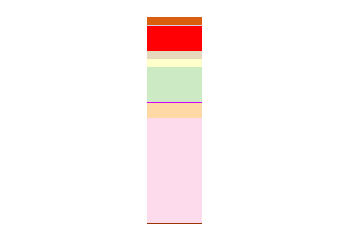

In [212]:
ax = single_seq_df[program_columns].plot.bar(stacked=True, width=0.1,
                        color=pal, linewidth=0.0, legend=False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [62]:
fimo_df[fimo_df['sequence_name'] == single_seq_id]

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
378708,16-TTCCTAGAAA,STREME-16,20211212_75659__621411__391::fsp__sknsh__0,145.0,154.0,-,15.97370,0.000002,0.1100,TTCCTGGAAA
390913,19-CKYAAGACGTM,STREME-19,20211212_75659__621411__391::fsp__sknsh__0,114.0,124.0,+,15.75000,0.000003,0.0783,CGGAAGACGTC
496007,94-RTGATGCATCAY,STREME-94,20211212_75659__621411__391::fsp__sknsh__0,81.0,92.0,+,13.19100,0.000005,0.1100,AGGATGCGTCCT
496008,94-RTGATGCATCAY,STREME-94,20211212_75659__621411__391::fsp__sknsh__0,81.0,92.0,-,13.19100,0.000005,0.1100,AGGACGCATCCT
557315,8-AAGGATGCTC,STREME-8,20211212_75659__621411__391::fsp__sknsh__0,129.0,138.0,+,14.98480,0.000007,0.0373,AAGGATGCGC
578630,2-GCHGTGATTTAY,STREME-2,20211212_75659__621411__391::fsp__sknsh__0,42.0,53.0,-,14.81970,0.000008,0.0190,GCTGAGATTTCT
696385,8-AAGGATGCTC,STREME-8,20211212_75659__621411__391::fsp__sknsh__0,50.0,59.0,-,14.04550,0.000011,0.0494,GAGGATGCTG
766441,24-CGTCGAAGAA,STREME-24,20211212_75659__621411__391::fsp__sknsh__0,122.0,131.0,-,13.36840,0.000015,0.1140,CTTCGAAGAC
792352,92-CATTCCTTTCAATTC,STREME-92,20211212_75659__621411__391::fsp__sknsh__0,152.0,166.0,-,11.57580,0.000016,0.0141,CATTACTCTAAATTC
797255,2-GCHGTGATTTAY,STREME-2,20211212_75659__621411__391::fsp__sknsh__0,20.0,31.0,-,13.26230,0.000016,0.0303,GCTGAGATTCCT


In [1210]:
hit_names = fimo_df[fimo_df['sequence_name'] == single_seq_id]['motif_id'].tolist()
strands = fimo_df[fimo_df['sequence_name'] == single_seq_id]['strand'].tolist()
for hit_name, strand in zip(hit_names, strands):
    print(strand, hit_name, boda2_streme_tfs[boda2_streme_tfs['motif_id'] == hit_name]['Target_ID'].item())

- 16-TTCCTAGAAA BCL6_HUMAN.H11MO.0.A
+ 19-CKYAAGACGTM JDP2_HUMAN.H11MO.0.D
+ 94-RTGATGCATCAY DBP_HUMAN.H11MO.0.B
- 94-RTGATGCATCAY DBP_HUMAN.H11MO.0.B
+ 8-AAGGATGCTC P73_HUMAN.H11MO.1.A
- 2-GCHGTGATTTAY GFI1_HUMAN.H11MO.0.C
- 8-AAGGATGCTC P73_HUMAN.H11MO.1.A
- 24-CGTCGAAGAA ZN680_HUMAN.H11MO.0.C
- 92-CATTCCTTTCAATTC ZN502_HUMAN.H11MO.0.C
- 2-GCHGTGATTTAY GFI1_HUMAN.H11MO.0.C
- 72-CTTTGGGAGGCCGAG ZN770_HUMAN.H11MO.1.C
+ 24-CGTCGAAGAA ZN680_HUMAN.H11MO.0.C
+ 96-GGAAWTTCC TF65_HUMAN.H11MO.0.A
- 96-GGAAWTTCC TF65_HUMAN.H11MO.0.A
+ 20-GATCAAAGGKC RXRG_HUMAN.H11MO.0.B
- 7-CCGTCGARG ZBTB4_HUMAN.H11MO.0.D
+ 16-TTCCTAGAAA BCL6_HUMAN.H11MO.0.A
+ 93-GATGCGC NRF1_HUMAN.H11MO.0.A
- 35-ACATTCCTTGGR TEAD4_HUMAN.H11MO.0.A
+ 76-AATCTCAGT GFI1B_HUMAN.H11MO.0.A
+ 76-AATCTCAGT GFI1B_HUMAN.H11MO.0.A
- 8-AAGGATGCTC P73_HUMAN.H11MO.1.A
+ 8-AAGGATGCTC P73_HUMAN.H11MO.1.A
+ 77-AAGGATG Z324A_HUMAN.H11MO.0.C
+ 94-RTGATGCATCAY DBP_HUMAN.H11MO.0.B
- 94-RTGATGCATCAY DBP_HUMAN.H11MO.0.B
- 19-CKYAAGACGTM JDP2_HUMAN.H

In [1203]:
for hit_name in fimo_df[fimo_df['sequence_name'] == single_seq_id]['motif_id'].tolist():

    print(boda2_streme_tfs[boda2_streme_tfs['motif_id'] == hit_name]['Target_ID_short'].item())

BCL6 (S-16)
JDP2 (S-19)
DBP (S-94)
DBP (S-94)
P73.1 (S-8)
GFI1 (S-2)
P73.1 (S-8)
ZN680 (S-24)
ZN502 (S-92)
GFI1 (S-2)
ZN770.1 (S-72)
ZN680 (S-24)
TF65 (S-96)
TF65 (S-96)
RXRG (S-20)
ZBTB4 (S-7)
BCL6 (S-16)
NRF1 (S-93)
TEAD4 (S-35)
GFI1B (S-76)
GFI1B (S-76)
P73.1 (S-8)
P73.1 (S-8)
Z324A (S-77)
DBP (S-94)
DBP (S-94)
JDP2 (S-19)
ZN410 (S-43)


In [98]:
hit_df = fimo_df[fimo_df['sequence_name'] == single_seq_id]
hit_df

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
378708,16-TTCCTAGAAA,STREME-16,20211212_75659__621411__391::fsp__sknsh__0,145.0,154.0,-,15.97370,0.000002,0.1100,TTCCTGGAAA
390913,19-CKYAAGACGTM,STREME-19,20211212_75659__621411__391::fsp__sknsh__0,114.0,124.0,+,15.75000,0.000003,0.0783,CGGAAGACGTC
496007,94-RTGATGCATCAY,STREME-94,20211212_75659__621411__391::fsp__sknsh__0,81.0,92.0,+,13.19100,0.000005,0.1100,AGGATGCGTCCT
496008,94-RTGATGCATCAY,STREME-94,20211212_75659__621411__391::fsp__sknsh__0,81.0,92.0,-,13.19100,0.000005,0.1100,AGGACGCATCCT
557315,8-AAGGATGCTC,STREME-8,20211212_75659__621411__391::fsp__sknsh__0,129.0,138.0,+,14.98480,0.000007,0.0373,AAGGATGCGC
578630,2-GCHGTGATTTAY,STREME-2,20211212_75659__621411__391::fsp__sknsh__0,42.0,53.0,-,14.81970,0.000008,0.0190,GCTGAGATTTCT
696385,8-AAGGATGCTC,STREME-8,20211212_75659__621411__391::fsp__sknsh__0,50.0,59.0,-,14.04550,0.000011,0.0494,GAGGATGCTG
766441,24-CGTCGAAGAA,STREME-24,20211212_75659__621411__391::fsp__sknsh__0,122.0,131.0,-,13.36840,0.000015,0.1140,CTTCGAAGAC
792352,92-CATTCCTTTCAATTC,STREME-92,20211212_75659__621411__391::fsp__sknsh__0,152.0,166.0,-,11.57580,0.000016,0.0141,CATTACTCTAAATTC
797255,2-GCHGTGATTTAY,STREME-2,20211212_75659__621411__391::fsp__sknsh__0,20.0,31.0,-,13.26230,0.000016,0.0303,GCTGAGATTCCT


In [69]:
hit_df['motif_id'].tolist()

['16-TTCCTAGAAA',
 '19-CKYAAGACGTM',
 '94-RTGATGCATCAY',
 '94-RTGATGCATCAY',
 '8-AAGGATGCTC',
 '2-GCHGTGATTTAY',
 '8-AAGGATGCTC',
 '24-CGTCGAAGAA',
 '92-CATTCCTTTCAATTC',
 '2-GCHGTGATTTAY',
 '72-CTTTGGGAGGCCGAG',
 '24-CGTCGAAGAA',
 '96-GGAAWTTCC',
 '96-GGAAWTTCC',
 '20-GATCAAAGGKC',
 '7-CCGTCGARG',
 '16-TTCCTAGAAA',
 '93-GATGCGC',
 '35-ACATTCCTTGGR',
 '76-AATCTCAGT',
 '76-AATCTCAGT',
 '8-AAGGATGCTC',
 '8-AAGGATGCTC',
 '77-AAGGATG',
 '94-RTGATGCATCAY',
 '94-RTGATGCATCAY',
 '19-CKYAAGACGTM',
 '43-ATTCCTTAAGA']

In [234]:
motif_ids = hit_df.sort_values('start')['motif_id'].tolist()

temp_array = []
short_names = []
for motif_id in motif_ids:
    temp_array.append(merged_tf_df[merged_tf_df['motif_id'] == motif_id][program_columns].values.reshape(-1))
    short_names.append(merged_tf_df[merged_tf_df['motif_id'] == motif_id]['Target_ID_short'].item())
temp_array = np.stack(temp_array)
temp_df = pd.DataFrame(temp_array)

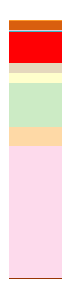

In [238]:
ax = single_seq_df[program_columns].plot.bar(stacked=True, width=10, figsize=(1,5),
                        color=pal, linewidth=0.0, legend=False)
plt.axis('off')

plt.show()

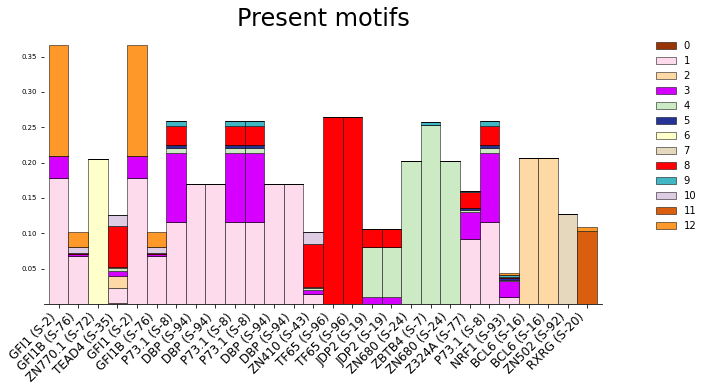

In [235]:
ax = temp_df.plot.bar(stacked=True, 
                    figsize=(10,5), 
                    width=1,
                    color=pal, 
                    fontsize='x-small',
                    edgecolor='black', 
                    linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticklabels(short_names, rotation=45, ha='right', fontsize=12)
ax.legend(bbox_to_anchor=(1.08, 1), fontsize='medium', labelspacing=0.5, frameon=False)
plt.title('Present motifs', fontsize=24)
plt.show()

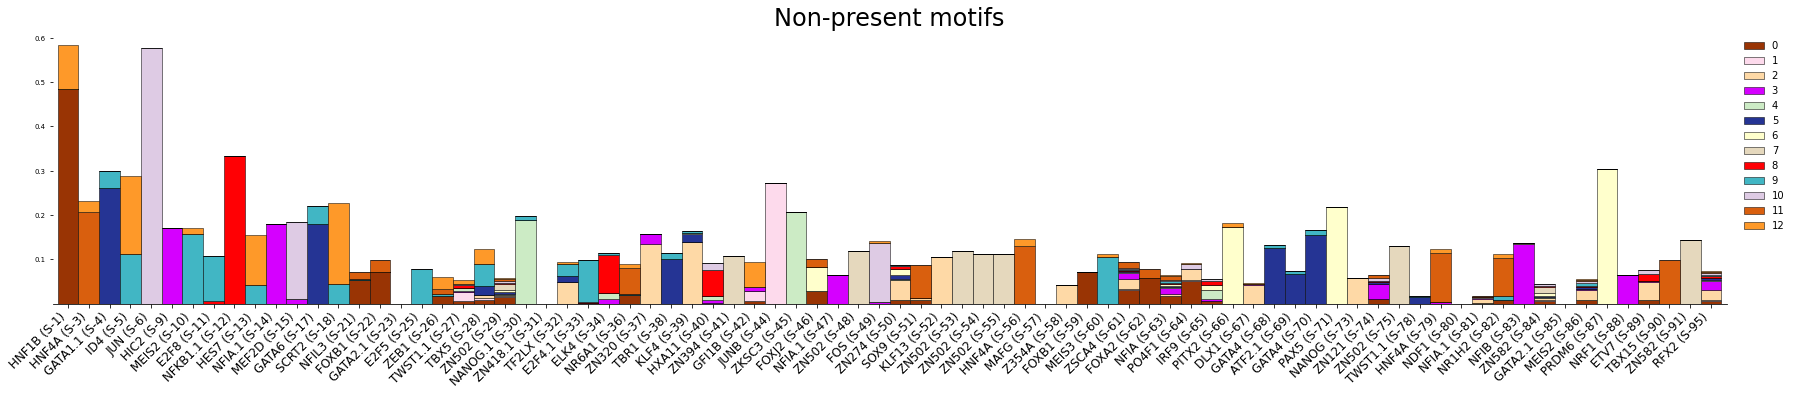

In [236]:
temp_df_2 = merged_tf_df[~merged_tf_df['motif_id'].isin(motif_ids)]

ax = temp_df_2[program_columns].plot.bar(stacked=True, 
                    figsize=(30,5), 
                    width=1,
                    color=pal, 
                    fontsize='x-small',
                    edgecolor='black', 
                    linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticklabels(temp_df_2['Target_ID_short'].tolist(), rotation=45, ha='right', fontsize=12)
ax.legend(bbox_to_anchor=(1.04, 1), fontsize='medium', labelspacing=0.5, frameon=False)
plt.title('Non-present motifs', fontsize=24)
plt.show()

In [237]:
for j in range(len(temp_df)):
    print(short_names[j])
    ax = temp_df.iloc[j].to_frame().T.plot.barh(stacked=True, width=10, figsize=(0.65,0.1), 
                            color=pal, linewidth=0.0, legend=False)
#     ax.spines['top'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.axis('off') 

    plt.show()

GFI1 (S-2)


GFI1B (S-76)


ZN770.1 (S-72)


TEAD4 (S-35)


GFI1 (S-2)


GFI1B (S-76)


P73.1 (S-8)


DBP (S-94)


DBP (S-94)


P73.1 (S-8)


P73.1 (S-8)


DBP (S-94)


DBP (S-94)


ZN410 (S-43)


TF65 (S-96)


TF65 (S-96)


JDP2 (S-19)


JDP2 (S-19)


ZN680 (S-24)


ZBTB4 (S-7)


ZN680 (S-24)


Z324A (S-77)


P73.1 (S-8)


NRF1 (S-93)


BCL6 (S-16)


BCL6 (S-16)


ZN502 (S-92)


RXRG (S-20)


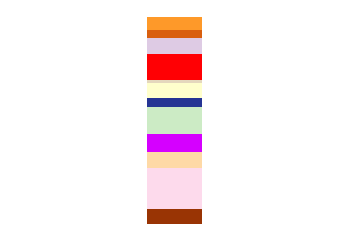

In [187]:
plot_df = temp_df.sum(axis=0).values - temp_df_2[program_columns].sum(axis=0).values
plot_df = (plot_df - plot_df.min()) / plot_df.max()
plot_df = pd.DataFrame(plot_df).T

ax = plot_df.plot.bar(stacked=True, width=0.1,
                        color=pal, linewidth=0.0, legend=False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [248]:
random.uniform(0, 0.25)

0.18450175180720013